In [1]:
from cerebralcortex.util.helper_methods import get_study_names
sn = get_study_names("/home/jupyter/cc3_conf/")
print(sn)
from pyspark.sql import functions as F
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.types import StructField, StructType, DoubleType,MapType, StringType,ArrayType, FloatType, TimestampType, IntegerType
from pyspark.sql.functions import minute, second, mean, window
from pyspark.sql import functions as F
import numpy as np
import pandas as pd
from cerebralcortex.core.datatypes import DataStream
from cerebralcortex.core.metadata_manager.stream.metadata import Metadata, DataDescriptor, \
ModuleMetadata
from typing import List
import numpy as np
from scipy import signal
import pandas as pd
from cerebralcortex import Kernel
CC = Kernel("/home/jupyter/cc3_conf/", study_name='rice')
# CC.list_streams()

['admin', 'dartmouth_sobc', 'default', 'demo', 'jhu_cocaine', 'mars_study', 'mcontain', 'md2k_aa_rice', 'md2k_affsci', 'md2k_labtest', 'md2k_ses_utah', 'md2k_test', 'memphis-test', 'memphis_test_study', 'moffitt', 'moffitt-test', 'moods', 'moods_backup', 'moral', 'mperf', 'mperf-alabsi', 'mperf-buder', 'mperf-mit-ll', 'mperf-test', 'northwestern_smoking', 'nu', 'opioid_study', 'osu', 'rice', 'robas', 'robas_study', 'sobclab', 'test', 'utah', 'utah_p01', 'vermont', 'vermont_smoking', 'wesad']


In [3]:
feature_stream = 'org.md2k.autosense.ecg.features.stndardized.rice.no.activity'
ecg_features = CC.get_stream(feature_stream).dropna()

from sklearn.preprocessing import StandardScaler
rip_features = CC.get_stream('org.md2k.autosense.rip.minute.features.standardized.final')

rip_features = rip_features.drop('timestamp','localtime','activity','day','version').withColumnRenamed('features','features_rip')

features = ecg_features.join(rip_features,on=['window','user'],how='inner')

df = features.withColumn('start',F.col('window').start)
df = df.withColumn('end',F.col('window').end).drop(*['window'])
schema = StructType([
    StructField("timestamp", TimestampType()),
    StructField("start", TimestampType()),
    StructField("end", TimestampType()),
    StructField("localtime", TimestampType()),
    StructField("version", IntegerType()),
    StructField("user", StringType()),
    StructField("day", StringType()),
    StructField("stress_likelihood", DoubleType()),
    StructField("activity", DoubleType())
])
import warnings
warnings.filterwarnings('ignore')
import pickle
from scipy import stats
ecg_model = pickle.load(open('./models/ecg_rip_model_final.p','rb'))

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
def ecg_r_peak(key,data):
    data = data.sort_values('timestamp').reset_index(drop=True)
    if data.shape[0]>60*12*.5:
        features = []
        ecg_features = np.array(data['features'])
        rip_features = np.array(data['features_rip'])
        for i in range(data.shape[0]):
            features.append(np.array(list(ecg_features[i])+list(rip_features[i])))
        features = np.nan_to_num(np.array(features))
#         for c in range(features.shape[1]):
#             features[:,c] = smooth(features[:,c],36)
        features = StandardScaler().fit_transform(np.nan_to_num(features))
#         features[features>=5] = 5
#         features[features<=-5] = -5
        probs = ecg_model.predict_proba(np.nan_to_num(features))[:,1]
        data['stress_likelihood'] = probs
        data = data[['timestamp','start','end','version','user','day','activity',
                     'localtime','stress_likelihood']]
        return data
    else:
        return pd.DataFrame([],columns=['timestamp','version','user','day','activity',
                                        'localtime','stress_likelihood','start','end'])

df_stress = df.groupBy(['user','day','version']).apply(ecg_r_peak)

df_stress.show(4,False)

df_stress = df_stress.select("user",'version','timestamp','localtime','day','activity',
              F.struct('start', 'end').alias('window'),'stress_likelihood')

schema = df_stress.schema
stream_metadata = Metadata()
stream_metadata.set_name('org.md2k.autosense.ecg.rip.stress.likelihood').set_description("Stress from Respiration")
for field in schema.fields:
    stream_metadata.add_dataDescriptor(
        DataDescriptor().set_name(str(field.name)).set_type(str(field.dataType))
    )
stream_metadata.add_module(
    ModuleMetadata().set_name("Respiration stress likelihood") \
    .set_attribute("url", "https://md2k.org").set_author(
        "Md Azim Ullah", "mullah@memphis.edu"))
stream_metadata.is_valid()
ds = DataStream(data=df_stress,metadata=stream_metadata)
CC.save_stream(ds,overwrite=True)

+-----------------------+-------------------+-------------------+-----------------------+-------+------------------------------------+--------+--------------------+--------+
|timestamp              |start              |end                |localtime              |version|user                                |day     |stress_likelihood   |activity|
+-----------------------+-------------------+-------------------+-----------------------+-------+------------------------------------+--------+--------------------+--------+
|2017-09-18 16:10:01.369|2017-09-18 16:09:30|2017-09-18 16:10:30|2017-09-18 10:10:01.369|1      |0c155e6b-410c-329e-8a06-66d01424ad53|20170918|0.03436288722751523 |0.0     |
|2017-09-18 16:10:01.369|2017-09-18 16:09:25|2017-09-18 16:10:25|2017-09-18 10:10:01.369|1      |0c155e6b-410c-329e-8a06-66d01424ad53|20170918|0.10128116382753467 |0.0     |
|2017-09-18 16:10:01.369|2017-09-18 16:09:45|2017-09-18 16:10:45|2017-09-18 10:10:01.369|1      |0c155e6b-410c-329e-8a06-66d01424a

True

In [4]:
ecg_model

Pipeline(memory=None,
         steps=[('sts',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=10,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('rf',
                 SVC(C=10, break_ties=False, cache_size=2000,
                     class_weight={0: 0.4, 1: 0.6}, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
                     gamma=0.004641588833612777, kernel='rbf', max_iter=-1,
                     probability=True, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [5]:
df_stress

DataFrame[user: string, version: int, timestamp: timestamp, localtime: timestamp, day: string, activity: double, window: struct<start:timestamp,end:timestamp>, stress_likelihood: double]

In [6]:
data = CC.get_stream('org.md2k.autosense.ecg.rip.stress.likelihood')

data = data.toPandas()
import pickle
pickle.dump(data,open('./data/rice_1st_version_ecg_rip1.p','wb'))

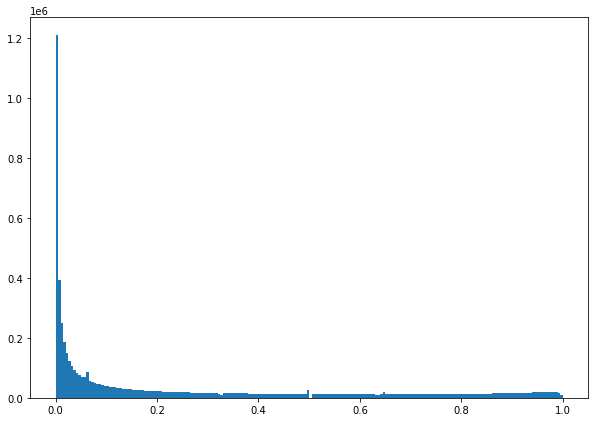

(6072523, 8)

In [7]:
# data = pickle.load(open('./data/rice_1st_version_ecg_rip1.p','rb'))
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.hist(data['stress_likelihood'],200)
plt.show()
data.shape

In [ ]:
data.user.unique()[:10],data.shape

data.groupby('user').count().sort_values('timestamp')[::-1]

# stress_data = data[data.user=='6c1a560d-85da-3c3b-b655-c46592e70406']
stress_data = data
count = 0
for day in stress_data.day.unique():
    plt.figure(figsize=(20,5))
    df = stress_data[stress_data.day==day].sort_values('timestamp').reset_index(drop=True)
    df['stress_likelihood'] = df['stress_likelihood'].rolling(window=72).mean()
    plt.plot(df['localtime'],df['stress_likelihood'],'--*')
    plt.ylim([0,1])
    plt.show()
# stress_data[stress_data.day=='20180913'].shape
stress_data.shape

In [8]:
stress_data = CC.get_stream('org.md2k.autosense.ecg.rip.stress.likelihood')
stress_data = stress_data.withColumn('day',F.date_format('localtime',"yyyyMMdd"))
stress_data = stress_data.withColumn('start',F.col('window').start)
stress_data = stress_data.withColumn('end',F.col('window').end).drop(*['window'])
stress_data = stress_data.withColumn('start',F.col('start').cast('double'))
stress_data = stress_data.withColumn('end',F.col('end').cast('double'))
stress_data = stress_data.withColumn('localtime',F.col('localtime').cast('double'))
stress_data = stress_data.withColumn('timestamp',F.col('timestamp').cast('double'))
stress_data  = stress_data.withColumn('likelihood_mean',F.lit(1))
stress_data.printSchema()

schema = StructType([
    StructField("timestamp", DoubleType()),
    StructField("start", DoubleType()),
    StructField("end", DoubleType()),
    StructField("localtime", DoubleType()),
    StructField("version", IntegerType()),
    StructField("user", StringType()),
    StructField("day", StringType()),
    StructField("stress_likelihood", DoubleType()),
    StructField("imputed", IntegerType()),
    StructField("likelihood_mean", DoubleType())
])
step = 5
smoothing = int(60*2/step)
@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
def impute_forwardfill(data):
    data = data[data.activity==0]
    data = data.sort_values('start').reset_index(drop=True)
#     data['stress_likelihood'] = data['stress_likelihood'].rolling(window=20).mean()
    data = data.dropna().sort_values('start').reset_index(drop=True)
    if data.shape[0]<.8*60*60/5:
        return pd.DataFrame([],columns=['timestamp','localtime','start','end',
                                          'version','user','day','stress_likelihood','likelihood_mean','imputed'])
    start = data['start'][0]
    all_rows = []
    median_stress = np.median(data['stress_likelihood'].values)
    for i,row in data.iterrows():
        if row['start']==start:
            all_rows.append([row['timestamp'],row['localtime'],row['start'],row['end'],
                             row['version'],row['user'],row['day'],row['stress_likelihood'],
                             row['likelihood_mean'],0])
            start = row['end']
        else:
            k = 1
            while (start+k*step)<=row['start']:
                all_rows.append([data.loc[i-1]['timestamp']+k*step,data.loc[i-1]['localtime']+k*step,
                                 data.loc[i-1]['start']+k*step,data.loc[i-1]['end']+k*step,
                                 row['version'],row['user'],row['day'],median_stress,data.loc[i-1]['likelihood_mean'],1])
                k+=1
            all_rows.append([row['timestamp'],row['localtime'],row['start'],row['end'],
                             row['version'],row['user'],row['day'],row['stress_likelihood'],
                             row['likelihood_mean'],0])
            start = row['end']    
    return pd.DataFrame(all_rows,columns=['timestamp','localtime','start','end',
                                          'version','user','day','stress_likelihood','likelihood_mean','imputed'])

stress_imputed_data = stress_data.groupBy(['user','day']).apply(impute_forwardfill)
stress_imputed_data = stress_imputed_data.withColumn('start',F.col('start').cast('timestamp'))
stress_imputed_data = stress_imputed_data.withColumn('end',F.col('end').cast('timestamp'))
stress_imputed_data = stress_imputed_data.withColumn('localtime',F.col('localtime').cast('timestamp'))
stress_imputed_data = stress_imputed_data.withColumn('timestamp',F.col('timestamp').cast('timestamp'))
cols = list(stress_imputed_data.columns)
cols.append(F.struct('start', 'end').alias('window'))
cols.remove('start')
cols.remove('end')
stress_imputed_data = stress_imputed_data.select(*cols)
stress_imputed_data.show(5,False)
schema = stress_imputed_data.schema
stream_metadata = Metadata()
stream_metadata.set_name("org.md2k.autosense.ecg.rip.stress.likelihood.imputed").set_description("rip stress imputed")
for field in schema.fields:
    stream_metadata.add_dataDescriptor(
        DataDescriptor().set_name(str(field.name)).set_type(str(field.dataType))
    )
stream_metadata.add_module(
    ModuleMetadata().set_name("stress forward fill imputed") \
    .set_attribute("url", "hhtps://md2k.org").set_author(
        "Md Azim Ullah", "mullah@memphis.edu"))
stream_metadata.is_valid()
ds = DataStream(data=stress_imputed_data,metadata=stream_metadata)
CC.save_stream(ds,overwrite=True)

root
 |-- timestamp: double (nullable = true)
 |-- localtime: double (nullable = true)
 |-- day: string (nullable = true)
 |-- activity: double (nullable = true)
 |-- stress_likelihood: double (nullable = true)
 |-- user: string (nullable = true)
 |-- version: integer (nullable = false)
 |-- start: double (nullable = true)
 |-- end: double (nullable = true)
 |-- likelihood_mean: integer (nullable = false)

+-----------------------+-----------------------+-------+------------------------------------+--------+--------------------+-------+---------------+------------------------------------------+
|timestamp              |localtime              |version|user                                |day     |stress_likelihood   |imputed|likelihood_mean|window                                    |
+-----------------------+-----------------------+-------+------------------------------------+--------+--------------------+-------+---------------+------------------------------------------+
|2017-06-29 09

True

In [ ]:
from sklearn.preprocessing import LabelEncoder
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder,LabelBinarizer
from sklearn import preprocessing
from sklearn import ensemble
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit,GridSearchCV,KFold,train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

def best_fit_slope(ys):
    return np.mean(np.diff(ys))

def get_features(y):
    tmp = y[-1,0]
    return [tmp,
#             np.median(y),
#             np.std(y),
#             np.percentile(y,80),
#             np.percentile(y,20),
            best_fit_slope(y[:,0])]

def get_trained_model(X_train,y_train):
    paramGrid = {'rf__n_neighbors':[3,4,5,6,7,8,9],
                 }
    clf = Pipeline([('rf',KNeighborsRegressor())])
    gkf = KFold(n_splits=5)
    grid_search = GridSearchCV(clf, paramGrid, n_jobs=-1,cv=gkf.split(X_train),
                               scoring='r2',verbose=5)
    grid_search.fit(X_train,y_train)
    clf = grid_search.best_estimator_
    clf.fit(X_train,y_train)
    return clf

weekday_dict = {'Wednesday':5,
                'Saturday':1,
                'Thursday':6,
                'Tuesday':4,
                'Friday':0,
                'Sunday':2,
                'Monday':3}
schema = StructType([
    StructField("timestamp", DoubleType()),
    StructField("start", DoubleType()),
    StructField("end", DoubleType()),
    StructField("localtime", DoubleType()),
    StructField("version", IntegerType()),
    StructField("user", StringType()),
    StructField("day", StringType()),
    StructField("weekday", StringType()),
    StructField("hour", IntegerType()),
    StructField("stress_probability", DoubleType()),
    StructField("imputed", IntegerType()),
])
@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
def fillup_imputation(data):
    data = data.sort_values('start').reset_index(drop=True)
#     data = data.dropna().sort_values('start').reset_index(drop=True)
    X = []
    y = []
    for i,row in data.iterrows():
        if i<lookback:
            continue
        if row['imputed'] in [1]:
            continue
        prev_imputed = list(data['imputed'].iloc[i-lookback:i].values)
        if prev_imputed.count(1)<=.33*lookback:
            feature = data[['stress_probability','imputed','timestamp']].iloc[i-lookback:i]
#             .sort_values('timestamp').reset_index(drop=True)
            feature = feature[feature.imputed.isin([0,2])][['stress_probability','timestamp']].values
            X.append(np.array(get_features(feature)+[row['hour'],weekday_dict[row['weekday']]]))
            y.append(row['stress_probability'])
    if len(X)<100:
        return data
    X = np.array(X)
    X_s = X[:,:-2]
    X_hour = X[:,-2:-1].reshape(-1,1)
    X_weekday = X[:,-1:].reshape(-1,1)
    clf_hour = OneHotEncoder().fit(np.arange(0,25,1).reshape(-1,1))
    clf_week_day = OneHotEncoder().fit(np.arange(0,7,1).reshape(-1,1))
    X_hour = clf_hour.transform(X_hour).todense().reshape(X.shape[0],-1)
    X_weekday = clf_week_day.transform(X_weekday).todense().reshape(X.shape[0],-1)
    X = np.concatenate([X_s,X_hour,X_weekday],axis=1)
    y = np.array(y)
    print(X.shape)
    clf = get_trained_model(X,y)
    start = data[data.imputed==1].shape[0]+1
#     return data
    count = 0
    while data[data.imputed==1].shape[0]<start and data[data.imputed==1].shape[0]>0:
        start = data[data.imputed==1].shape[0]
        print(start,count)
        X = []
        y = []
        index = []
        for i,row in data.iterrows():
            if i<lookback:
                continue
            if row['imputed'] in [0,2]:
                continue
            prev_imputed = list(data['imputed'].iloc[i-lookback:i].values)
            if prev_imputed.count(1)<=.33*lookback:
                feature = data[['stress_probability','imputed','timestamp']].iloc[i-lookback:i]
#                 .sort_values('timestamp').reset_index(drop=True)
                feature = feature[feature.imputed.isin([0,2])][['stress_probability','timestamp']].values
                X.append(np.array(get_features(feature)+[row['hour'],weekday_dict[row['weekday']]]))
                y.append(row['stress_probability'])
                index.append(i)
        count+=1
        if len(X)==0:
            break
        X = np.array(X)
        X_s = X[:,:-2]
        X_hour = X[:,-2:-1].reshape(-1,1)
        X_weekday = X[:,-1:].reshape(-1,1)
        X_hour = clf_hour.transform(X_hour).todense().reshape(X.shape[0],-1)
        X_weekday = clf_week_day.transform(X_weekday).todense().reshape(X.shape[0],-1)
        X = np.concatenate([X_s,X_hour,X_weekday],axis=1)
#         break
        data.loc[index,'stress_probability'] = clf.predict(X).reshape(-1)
        data.loc[index,'imputed'] = 2
    return data

from sklearn.impute import KNNImputer

# @pandas_udf(schema, PandasUDFType.GROUPED_MAP)
# def fillup_imputation_simple(data):
# #     data = data.sort_values('start').reset_index(drop=True)
# #     data['stress_probability'] = data['stress_probability'].rolling(window=lookback).mean()
#     data = data.dropna().sort_values('start').reset_index(drop=True)
#     if data.shape[0]<1000:
#         return data
#     Xs = []
#     Xweekday = []
#     Xhour = []
#     index = []
#     for i,row in data.iterrows():
#         if row['imputed'] in [1]:
#             Xs.append(np.nan)
#             index.append(i)
#         else:
#             Xs.append(row['stress_probability'])
#         Xweekday.append(weekday_dict[row['weekday']])
#         Xhour.append(row['hour'])
#     X_s = np.array(Xs).reshape(-1,1)
#     clf_hour = OneHotEncoder().fit(np.arange(0,25,1).reshape(-1,1))
#     clf_week_day = OneHotEncoder().fit(np.arange(0,7,1).reshape(-1,1))
#     X_hour = clf_hour.transform(np.array(Xhour).reshape(-1,1)).todense().reshape(X_s.shape[0],-1)
#     X_weekday = clf_week_day.transform(np.array(Xweekday).reshape(-1,1)).todense().reshape(X_s.shape[0],-1)
#     X = np.concatenate([X_hour,X_weekday,X_s],axis=1)
#     imputer = KNNImputer(n_neighbors=10)
#     X = imputer.fit_transform(X)[np.array(index)]
#     data.loc[index,'stress_probability'] = X[:,-1]
#     data.loc[index,'imputed'] = 2
#     return data

step = 5
lookback = int(3*(60/5))
stream_name = "org.md2k.autosense.ecg.rip.stress.likelihood.imputed"
stress_data = CC.get_stream(stream_name)
stress_data = stress_data.withColumnRenamed('stress_likelihood','stress_probability').drop('likelihood_mean')
# stress_data = stress_data.withColumn('day',F.date_format('localtime',"yyyyMMdd"))
stress_data = stress_data.withColumn('start',F.col('window').start)
stress_data = stress_data.withColumn('end',F.col('window').end).drop(*['window'])
stress_data = stress_data.withColumn('start',F.col('start').cast('double'))
stress_data = stress_data.withColumn('end',F.col('end').cast('double'))
stress_data = stress_data.withColumn('hour',F.hour('localtime'))
stress_data = stress_data.withColumn('weekday',F.date_format('localtime','EEEE'))
stress_data = stress_data.withColumn('localtime',F.col('localtime').cast('double'))
stress_data = stress_data.withColumn('timestamp',F.col('timestamp').cast('double'))
stress_data.show(5,False)
# data_1 = stress_data._data.toPandas()
stress_imputed_data = stress_data.groupBy(['user','version']).apply(fillup_imputation)
stress_imputed_data = stress_imputed_data.withColumn('start',F.col('start').cast('timestamp'))
stress_imputed_data = stress_imputed_data.withColumn('end',F.col('end').cast('timestamp'))
stress_imputed_data = stress_imputed_data.withColumn('localtime',F.col('localtime').cast('timestamp'))
stress_imputed_data = stress_imputed_data.withColumn('timestamp',F.col('timestamp').cast('timestamp'))
cols = list(stress_imputed_data.columns)
cols.append(F.struct('start', 'end').alias('window'))
cols.remove('start')
cols.remove('end')
cols.remove('hour')
# cols.remove('weekday')
# cols.remove('day')
stress_imputed_data = stress_imputed_data.select(*cols)
stress_imputed_data = stress_imputed_data.withColumn('localtime_str',F.col('localtime').cast('string'))
stress_imputed_data.show(10,False) 
schema = stress_imputed_data.schema
stream_metadata = Metadata()
stream_metadata.set_name("org.md2k.autosense.ecg.rip.stress.likelihood.imputed.all").set_description("stress imputed")
for field in schema.fields:
    stream_metadata.add_dataDescriptor(
        DataDescriptor().set_name(str(field.name)).set_type(str(field.dataType))
    )
stream_metadata.add_module(
    ModuleMetadata().set_name("stress imputed in KNN") \
    .set_attribute("url", "hhtps://md2k.org").set_author(
        "Md Azim Ullah", "mullah@memphis.edu"))
stream_metadata.is_valid()
ds = DataStream(data=stress_imputed_data,metadata=stream_metadata)
CC.save_stream(ds,overwrite=True)
# stream_metadata

In [ ]:
data = CC.get_stream("org.md2k.autosense.ecg.rip.stress.likelihood.imputed")
data = data.toPandas()
import pickle
pickle.dump(data,open('./data/rice_1st_version_ecg_rip_imputed_all.p','wb'))

In [ ]:
# data = pickle.load(open('./data/rice_1st_version_ecg_rip_imputed.p','rb'))
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.hist(data['stress_likelihood'][data['imputed']==0],200)
plt.show()

In [ ]:
data.user.unique()[:10],data.shape

In [ ]:
stress_data = data[data.user=='cd55ae15-ee0e-3527-b7f5-d5a4897d5b8e']

In [ ]:
count = 0
for day in stress_data.day.unique():
    plt.figure(figsize=(20,10))
    df = stress_data[stress_data.day==day].sort_values('timestamp').reset_index(drop=True)
    df['stress_likelihood'] = df['stress_likelihood'].rolling(window=72).mean()
    plt.plot(df['localtime'],df['stress_likelihood'],'--*')
    plt.ylim([0,1])
    plt.show()

In [ ]:
# stress_data[stress_data.day=='20180913'].shape
# stress_data.shape

In [ ]:
macd_param_fast = 7*12
macd_param_slow = 19*12
macd_param_signal = 2*12
smoothing_window = 3*12 # FIXME - 3 minutes
threshold_stressed = 0.36
threshold_not_stressed= 0.36
NOTSTRESS = "NOTSTRESSED"
UNSURE = 'UNSURE'
YESSTRESS = 'STRESSED'
UNKNOWN = 'UNKNOWN'
UNCLASSIFIED = 'UNCLASSIFIED'
stream_name = "org.md2k.autosense.ecg.stress_episodes"

def stress_episodes_estimation(stress_data: object) -> object:
    stress_data = stress_data.sort_values('timestamp').reset_index(drop=True)
    """
    smooth stress probabilities and use MACD to label stress episodes
    Args:
        stress_data (pandas.df):
    Returns:
        pandas.df
    """
    
    user_id = stress_data.iloc[0].user
    # Smooth the stress values
    stress_smoothed_list = []

    for indx in range(len(stress_data['stress_probability'].values)):
        if indx<2:
            smoothed_stress = stress_data['stress_probability'].values[indx]
        else:
            smoothed_stress = (stress_data['stress_probability'].values[indx] + \
                             stress_data['stress_probability'].values[indx-1] + \
                             stress_data['stress_probability'].values[indx-2]) / smoothing_window

        stress_smoothed_list.append((stress_data['timestamp'].values[indx], smoothed_stress, stress_data['localtime'].values[indx]))

    # EMA = Exponential Moving Average
    ema_fast_list = []
    ema_fast_list.append(stress_smoothed_list[0])
    ema_slow_list = []
    ema_slow_list.append(stress_smoothed_list[0])
    ema_signal_list = []
    ema_signal_list.append((0,0))
    histogram_list = []

    stress_episode_start = []
    stress_episode_peak = []
    stress_episode_classification = []
    stress_episode_intervals = []

    for indx in range(len(stress_smoothed_list)):
        if indx%100==0:
            print(indx)
        ema_fast_prev = ema_fast_list[-1][1]
        ema_fast_current = stress_smoothed_list[indx][1]
        ema_fast = ewma(ema_fast_current, ema_fast_prev, 2.0/(macd_param_fast + 1))
        ema_fast_list.append((stress_smoothed_list[indx][0], ema_fast))

        ema_slow_prev = ema_slow_list[-1][1]
        ema_slow_current = stress_smoothed_list[indx][1]
        ema_slow = ewma(ema_slow_current, ema_slow_prev, 2.0/(macd_param_slow + 1))
        ema_slow_list.append((stress_smoothed_list[indx][0], ema_slow))

        macd_prev = ema_fast_prev - ema_slow_prev
        macd_current = ema_fast_current - ema_slow_current
        ema_signal_prev = ema_signal_list[-1][1]
        ema_signal = ewma(macd_current, macd_prev, 2.0/(macd_param_signal + 1))
        ema_signal_list.append((stress_smoothed_list[indx][0], ema_signal))

        histogram_prev =  macd_prev - ema_signal_prev
        histogram = macd_current - ema_signal
        histogram_list.append((stress_smoothed_list[indx][0], histogram))

        if histogram_prev <=0 and histogram > 0:
            # Episode has ended, started increasing again
            start_timestamp = None;
            peak_timestamp = None;
            end_timestamp = stress_smoothed_list[indx][0]
            stress_class = None
            if len(stress_episode_start):
                start_timestamp = stress_episode_start[-1][0]

            if len(stress_episode_classification):
                peak_timestamp = stress_episode_classification[-1][0]
                stress_class = stress_episode_classification[-1][1]

            if stress_class:
                #TODO - Handle this?????
                stress_episode_timestamps = []
                stress_episode_timestamps.append(start_timestamp)
                stress_episode_timestamps.append(peak_timestamp)
                stress_episode_timestamps.append(end_timestamp)
                stress_episode_timestamps.append(stress_class)
                stress_episode_intervals.append(stress_episode_timestamps)

        if histogram_prev >=0 and histogram < 0:
            # Episode is in the middle, started decreasing
            episode_start_timestamp = get_episode_start_timestamp(stress_episode_classification, histogram_list, stress_smoothed_list[indx][0])
            if episode_start_timestamp is None:
                stress_episode_start.append((episode_start_timestamp, UNCLASSIFIED))
                stress_episode_peak.append((stress_smoothed_list[indx][0], UNCLASSIFIED))
                stress_episode_classification.append([stress_smoothed_list[indx][0], stress_smoothed_list[indx][2], stress_smoothed_list[indx][1], UNCLASSIFIED])
            else:
                proportion_available = get_proportion_available(stress_data, episode_start_timestamp, stress_smoothed_list[indx][0])
                if proportion_available < 0.5:
                    stress_episode_start.append((episode_start_timestamp, UNKNOWN))
                    stress_episode_peak.append((stress_smoothed_list[indx][0], UNKNOWN))
                    stress_episode_classification.append([stress_smoothed_list[indx][0], stress_smoothed_list[indx][2], stress_smoothed_list[indx][1], UNKNOWN])
                else:
                    historical_stress = get_historical_values_timestamp_based(stress_smoothed_list, episode_start_timestamp, stress_smoothed_list[indx][0])
                    if not len(historical_stress):
                        stress_episode_start.append((episode_start_timestamp, UNKNOWN))
                        stress_episode_peak.append((stress_smoothed_list[indx][0], UNKNOWN))
                        stress_episode_classification.append([stress_smoothed_list[indx][0], stress_smoothed_list[indx][2], stress_smoothed_list[indx][1], UNKNOWN])
                    else:
                        cumu_sum = 0.0
                        for hs in historical_stress:
                            cumu_sum += hs[1]
                        stress_density = cumu_sum / len(historical_stress)
                        if stress_density >= threshold_stressed:
                            stress_episode_start.append((episode_start_timestamp, YESSTRESS))
                            stress_episode_peak.append((stress_smoothed_list[indx][0], YESSTRESS))
                            stress_episode_classification.append([stress_smoothed_list[indx][0], stress_smoothed_list[indx][2], stress_smoothed_list[indx][1], YESSTRESS])
                        elif stress_density <= threshold_not_stressed:
                            stress_episode_start.append((episode_start_timestamp, NOTSTRESS))
                            stress_episode_peak.append((stress_smoothed_list[indx][0], NOTSTRESS))
                            stress_episode_classification.append([stress_smoothed_list[indx][0], stress_smoothed_list[indx][2], stress_smoothed_list[indx][1], NOTSTRESS])
                        else:
                            stress_episode_start.append((episode_start_timestamp, UNSURE))
                            stress_episode_peak.append((stress_smoothed_list[indx][0], UNSURE))
                            stress_episode_classification.append([stress_smoothed_list[indx][0], stress_smoothed_list[indx][2], stress_smoothed_list[indx][1], UNSURE])

    df = pd.DataFrame(stress_episode_classification, columns=['timestamp', 'localtime', 'stress_probability', 'stress_episode'])
    df['user'] = user_id
    df['version'] = 1
    return df

def ewma(current:int, previous:int, alpha:int)->float:
    """
    compute exponential weighted moving average
    Args:
        current (int): current stress probability value
        previous (int): previous stress probability value
        alpha (int):
    Returns:
        float
    """
    return alpha * current + (1 - alpha) * previous

def get_episode_start_timestamp(stress_episode_classification, histogram_list, currenttime):
    """
    Get start time of a stress episode
    Args:
        stress_episode_classification:
        histogram_list:
        currenttime:
    Returns:
    """
    timestamp_prev = None
    if len(stress_episode_classification) >= 3:
        timestamp_prev = stress_episode_classification[-3][0]
    elif len(stress_episode_classification) == 2:
        timestamp_prev = stress_episode_classification[-2][0]
    elif len(stress_episode_classification) == 1:
        timestamp_prev = stress_episode_classification[-1][0]

    histogram_history =  get_historical_values_timestamp_based(histogram_list, timestamp_prev, currenttime)

    if len(histogram_history) <= 1:
        return None

    for x in range(len(histogram_history)-2 , -1, -1):
        if histogram_history[x][1] <= 0:
            return histogram_history[x+1][0]

    return histogram_history[0][0]


def get_historical_values_timestamp_based(data, start_timestamp, currenttime):
    """
    Args:
        data:
        start_timestamp:
        currenttime:
    Returns:
    """
    toreturn = []
    starttime = start_timestamp
    if starttime == None:
        starttime = currenttime - np.timedelta64(100*365*24*3600, 's') # approx 100 year to approximate -1
    for c in data:
        if c[0] >= starttime and c[0] <= currenttime:
            toreturn.append(c)
        if c[0] > currenttime:
            break

    return toreturn


def get_proportion_available(data, st, current_timestamp):
    """
    compute the ratio of (detected + imputed stress episodes)/detected stress episodes
    Args:
        data:
        st:
        current_timestamp:
    Returns:
    """
    count = 0
    available = 0
    start_timestamp = st
    if start_timestamp is None:
        start_timestamp = current_timestamp
    for x in range(len(data)):
        row_time = data.iloc[x]['timestamp']
        if row_time >= start_timestamp and row_time <= current_timestamp:
            available += data.iloc[x]['imputed']
            count +=1
        if row_time > current_timestamp:
            break

    if count:
        return available/count

    return 0

In [ ]:
import pickle
data = pickle.load(open('./data/rice_1st_version_ecg_rip_imputed.p','rb'))

data['stress_probability'] = data['stress_likelihood']

ecg_stress_probability = data[(data.user=='cd55ae15-ee0e-3527-b7f5-d5a4897d5b8e')&(data.day=='20180419')]

In [ ]:
ecg_stress_probability.head()

In [ ]:
data = ecg_stress_probability.groupby(['user','day','version'],as_index=False).apply(stress_episodes_estimation)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,10))
plt.vlines(data[data.stress_probability>.01]['timestamp'],0,1,'k')
plt.plot(ecg_stress_probability['timestamp'],ecg_stress_probability['stress_probability'])

In [ ]:
data
